<a href="https://colab.research.google.com/github/mylethidiem/data-science-artificial-intelligence-projects/blob/mylethidiem%2Ftemporal_fusion_transformer/Temporal-Fusion-Transformer/notebooks/temporal-fusion-transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demand forecasting with the Temporal Fusion Transformer


ℹ️Notes:
- This english version and this keep `the baseline information` and add `my new explain`
- Reference source code [here](https://pytorch-forecasting.readthedocs.io/en/v1.4.0/tutorials/stallion.html)
- My Notes [here](https://www.notion.so/Temporal-Fusion-Transformers-for-Time-Series-Forecasting-2a10730a9673809c9956fb4e331f073c?v=2240730a967380c8a397000c5c7e4026&source=copy_link)

In this tutorial, we will train the `~pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer` on a very small dataset to demonstrate that it even does a good job on only 20k samples. Generally speaking, it is a large model and will therefore perform much better with more data.

Our example is a demand forecast from the [Stallion kaggle competition](https://www.kaggle.com/utathya/future-volume-prediction).


## Setting Up the Development Environment

In [1]:
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [2]:
!pip -q install lightning pytorch_forecasting pytorch_optimizer

In [3]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor # Callbacks
from lightning.pytorch.loggers import TensorBoardLogger # Logger: Record training progress for monitoring with TensorBoard
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters, # Tool for automatic hyperparameter optimization
)

In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU (CUDA) is available.")
    print(f"Current device: {torch.cuda.get_device_name(0)}")
    device = "cuda"
else:
    print("Using CPU.")
    device = "cpu"

## Prepare data

First, we need to transform our time series into a pandas dataframe where each row can be identified with a time step and a time series. Fortunately, most datasets are already in this format. For this tutorial, we will use the [Stallion dataset from Kaggle](https://www.kaggle.com/utathya/future-volume-prediction) describing sales of various beverages. Our task is to make a six-month forecast of the sold volume by stock keeping units (SKU), that is products, sold by an agency, that is a store. There are about 21 000 monthly historic sales records. In addition to historic sales we have information about the sales price, the location of the agency, special days such as holidays, and volume sold in the entire industry.

The dataset is already in the correct format but misses some important features. Most importantly, we need to add a time index that is incremented by one for each time step. Further, it is beneficial to add date features, which in this case means extracting the month from the date record.


### Feature Engineering and Data Preprocessing

In [4]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# --- 1. Start Creating Index and New Features ---

# Add time index to create a continuous time series
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min() # Normalize time_idx so that it starts at 0.

# Add additional features
data["month"] = data.date.dt.month.astype(str).astype(
    "category"
)  # convert to string and category, categories have be strings

# Apply log(volume) to stabilize variance and reduce the impact of outliers
data["log_volume"] = np.log(data.volume + 1e-8)

# Calculate the mean volume by each SKU (product) at each time step (time_idx)
data["avg_volume_by_sku"] = data.groupby(
    ["time_idx", "sku"], observed=True
).volume.transform("mean")

# Calculate the mean volume by each agency (store) at each time step (time_idx)
data["avg_volume_by_agency"] = data.groupby(
    ["time_idx", "agency"], observed=True
).volume.transform("mean")


# --- 2. Process Special Days (Reverse One-Hot Encoding) ---

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
# List of columns representing special days (currently in one-hot form: 0/1)
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]

# Convert the special_days columns from one-hot (0/1) to a single categorical column:
# 0 is replaced by '-' (not a special day), 1 is replaced by the column name (the name of the special day).
data[special_days] = (
    data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
)

data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [5]:
data.describe()

,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,21000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,2015-06-16 20:48:00,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
min,0.000000,2013-01-01 00:00:00,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,2014-03-24 06:00:00,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,2015-06-16 00:00:00,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,2016-09-08 12:00:00,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,2017-12-01 00:00:00,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375
std,2711.496882,NaN,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698


### Create dataset and dataloaders


The next step is to convert the dataframe into a PyTorch Forecasting `pytorch_forecasting.data.timeseries.TimeSeriesDataSet`. Apart from telling the dataset which features are categorical vs continuous and which are static vs varying in time, we also have to decide how we normalise the data. Here, we standard scale each time series separately and indicate that values are always positive. Generally, the class `pytorch_forecasting.data.encoders.EncoderNormalizer`, that scales dynamically on each encoder sequence as you train, is preferred to avoid look-ahead bias induced by normalisation. However, you might accept look-ahead bias if you are having troubles to find a reasonably stable normalisation, for example, because there are a lot of zeros in your data. Or you expect a more stable normalization in inference. In the later case, you ensure that you do not learn "weird" jumps that will not be present when running inference, thus training on a more realistic data set.

We also choose to use the last six months as a validation set.

In [6]:
# --- Input Data Configuration ---

max_prediction_length = 6  # Forecast 6 time steps (months)
max_encoder_length = 24    # Maximum history length (Encoder): Use the previous 24 time steps for training
# Define the cutoff point: All data before the last 6 months will be used for training
training_cutoff = data["time_idx"].max() - max_prediction_length

# 1. Create the Training Dataset
training = TimeSeriesDataSet(
    # Only take data before the cutoff point (training_cutoff)
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",  # Continuous time index column
    target="volume",      # Target variable to predict (is volume)
    group_ids=["agency", "sku"],  # Columns that define a unique time series (Agency + SKU)
    min_encoder_length=max_encoder_length
    // 2,  # Minimum history length (is 1/2 of max length)
    max_encoder_length=max_encoder_length,  # Maximum history length (24 months)
    min_prediction_length=1,
    max_prediction_length=max_prediction_length, # Prediction length (6 months)

    # Categorical columns that DO NOT change over time (Static)
    static_categoricals=["agency", "sku"],
    # Numerical columns that DO NOT change over time (e.g., population info, income)
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],

    # Categorical columns that change over time AND are KNOWN in the future (e.g., what the next month is)
    time_varying_known_categoricals=["special_days", "month"],
    # Group related categorical variables into one group for processing
    variable_groups={
        "special_days": special_days
    },
    # Numerical columns that change over time AND are KNOWN in the future (e.g., planned price)
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],

    # Categorical columns that change over time AND are UNKNOWN in the future (none)
    time_varying_unknown_categoricals=[],
    # Numerical columns that change over time AND are UNKNOWN in the future (used to learn relationships)
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],

    # Target normalization: Use GroupNormalizer (normalize by Agency/SKU group) and softplus function (ensures positive output)
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),
    add_relative_time_idx=True, # Add relative time index
    add_target_scales=True,     # Add information about the target variable's scale (important for GroupNormalizer)
    add_encoder_length=True,    # Add encoder length (helps the model learn when history length varies)
)

# 2. Create the Validation Set
# Use the configured training data structure, but apply it to the entire original DataFrame (data).
# predict=True: Requests samples where the last 6 months are used as the target for validation.
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)

# 3. Create DataLoaders for PyTorch
batch_size = 128  # set this between 32 to 128
# Training DataLoader: shuffle (train=True) and use batch size 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
# Validation DataLoader: no shuffle (train=False) and use a larger batch size (faster for evaluation)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

To learn more about the class `~pytorch_forecasting.data.timeseries.TimeSeriesDataSet`, visit its documentation or the `tutorial explaining how to pass datasets to models <passing-data>`.

## Create baseline model


Evaluating a class `~pytorch_forecasting.models.baseline.Baseline` model that predicts the next 6 months by simply repeating the last observed volume
gives us a simle benchmark that we want to outperform.

In [7]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: True, using: 1 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: True, using: 1 TPU cores


tensor(293.0088, device='xla:0')

## Train the Temporal Fusion Transformer

It is now time to create our class `~pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer` model. We train the model with PyTorch Lightning.

### Find optimal learning rate


Prior to training, you can identify the optimal learning rate with the [PyTorch Lightning learning rate finder](https://pytorch-lightning.readthedocs.io/en/latest/lr_finder.html).


In [8]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator=device,
    # Clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    # Set maximum value for gradient clipping to prevent exploding gradients
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # Size of the hidden state (a critical hyperparameter)
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1, # Number of attention heads in the multi-head attention block
    dropout=0.1,  # Dropout rate (regularization technique)
    hidden_continuous_size=8,  # Size of hidden layer for continuous variables (set <= hidden_size)
    loss=QuantileLoss(), # Loss function used for training (Quantile Loss is common for TFT)
    optimizer="ranger", # Optimization algorithm (Ranger is a robust optimizer)
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)

print(f"Number of trainable parameters in network: {tft.size() / 1e3:.1f}k")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: True, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: True, using: 0 TPU cores


Number of trainable parameters in network: 13.5k


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: True, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: True, using: 0 TPU cores


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 94 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 94 steps due to diverging loss.
INFO: Restoring states from the checkpoint path at /content/.lr_find_9787c9e4-6f84-4874-856c-bc57f2d29ce9.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_9787c9e4-6f84-4874-856c-bc57f2d29ce9.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_9787c9e4-6f84-4874-856c-bc57f2d29ce9.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_9787c9e4-6f84-4874-856c-bc57f2d29ce9.ckpt
INFO: Learning rate set to 9.549925860214362e-06
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 9.549925860214362e-06


suggested learning rate: 9.549925860214362e-06


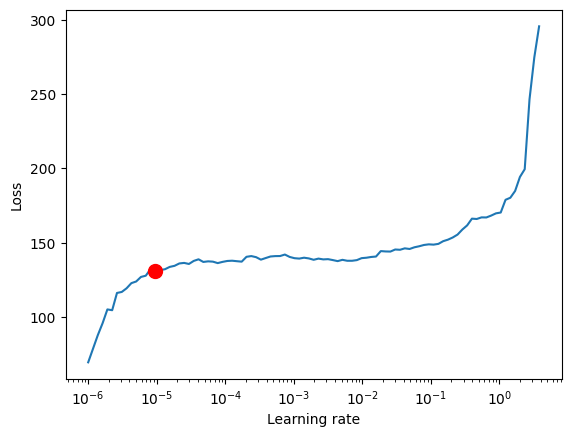

In [17]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner
# Initialize the Tuner using the configured trainer
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
# Plot the loss versus learning rate curve to visualize the optimal point
fig = res.plot(show=True, suggest=True)
fig.show()

For the class `~pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer`, the optimal learning rate seems to be slightly lower than the suggested one. Further, we do not directly want to use the suggested learning rate because PyTorch Lightning sometimes can get confused by the noise at lower learning rates and suggests rates far too low. Manual control is essential. We decide to pick 0.03 as learning rate.

### Train model


If you have troubles training the model and get an error `AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'`, consider either uninstalling tensorflow or first execute

````py
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [10]:
!pip -q install -U tensorboardX tensorboard

In [18]:
# configure network and trainer
# Define EarlyStopping mechanism (a callback)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,      # Minimum change required to count as an improvement
    patience=10,         # Number of epochs to wait for improvement before stopping
    verbose=False,
    mode="min"           # Stop when the monitored metric minimizes
)
lr_logger = LearningRateMonitor()  # Log the learning rate during training (a callback)
logger = TensorBoardLogger("lightning_logs")  # Logger to save training results and metrics to TensorBoard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator=device,
    enable_model_summary=True, # Show a summary of the model structure
    gradient_clip_val=0.1, # Clip gradients to prevent exploding gradients
    limit_train_batches=50,  # Limit the number of training batches per epoch (e.g., for quick testing)
    # fast_dev_run=True,
    callbacks=[lr_logger, early_stop_callback], # List of callbacks to use during training
    logger=logger,       # Assign the TensorBoard logger
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,      # Size of the hidden state (key hyperparameter)
    attention_head_size=2,
    dropout=0.1,         # Dropout rate for regularization
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # Log metrics every 10 batches during training
    optimizer="ranger",
    reduce_on_plateau_patience=4, # Patience for reducing the learning rate if validation loss plateaus
)
# Print the total number of trainable parameters in the network
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: True, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: True, using: 0 TPU cores


Number of parameters in network: 29.4k


Training takes a couple of minutes on my Macbook but for larger networks and datasets, it can take hours. The training speed is here mostly determined by overhead and choosing a larger `batch_size` or `hidden_size` (i.e. network size) does not slow does training linearly making training on large datasets feasible. During training, we can monitor the tensorboard which can be spun up with `tensorboard --logdir=lightning_logs`. For example, we can monitor examples predictions on the training and validation set.


In [19]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K  | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


### Hyperparameter tuning


Hyperparamter tuning with [optuna](https://optuna.org/) is directly build into pytorch-forecasting [link text](https://)ng. For example, we can use the
func `~pytorch_forecasting.models.temporal_fusion_transformer.tuning.optimize_hyperparameters` function to optimize the TFT's hyperparameters.

In [15]:
!pip -q install optuna statsmodels optuna-integration[pytorch_lightning]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 5.6 MB/s eta 0:00:00


In [20]:
import pickle  # Module for serializing and deserializing Python objects (saving/loading data)
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
 # create study
# Start hyperparameter optimization using the Optuna framework
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test", # Path to save intermediate best models
    n_trials=200,     # Total number of different hyperparameter combinations to test
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0), # Range for gradient clipping value
    hidden_size_range=(8, 128),  # Range for hidden layer size (key hyperparameter)
    hidden_continuous_size_range=(8, 128), # Range for hidden size of continuous variables
    attention_head_size_range=(1, 4), # Range for the number of attention heads
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    # Trainer arguments: limit training to 30 batches per epoch to speed up trials
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4, # Stop trial if validation loss doesn't improve after 4 epochs
    # Disable built-in learning rate finder, rely on Optuna to find the best LR
    use_learning_rate_finder=False,
)
# save study results - also we can resume tuning at a later point in time
# Open a file in binary write mode ("wb")
with open("test_study.pkl", "wb") as fout:
    # Save the entire Optuna study object to the file
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2025-11-20 13:44:29,611] A new study created in memory with name: no-name-ea070d19-2414-4564-b7fc-5172997376c4
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: True, using: 1 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: True, using: 1 TPU cores
[W 2025-11-20 13:44:33,117] Trial 0 failed with parameters: {'gradient_clip_val': 0.6798179116343376, 'hidden_size': 27, 'dropout': 0.10602701740100302, 'hidden_continuous_size': 21, 'attention_head_size': 2, 'learning_rate': 0.007322475082890742} because of the following error: RuntimeError("The tensor has a non-zero number of elements, but its data is not allocated yet.\nIf you're using torch.compile/export/fx, it is likely that we are erroneously tracing into a custom kernel. To fix this, please wrap the custom kernel into an opaque custom op. Please see the following for details: https://pytorch.org/tutorials/advanced/custom_ops

RuntimeError: The tensor has a non-zero number of elements, but its data is not allocated yet.
If you're using torch.compile/export/fx, it is likely that we are erroneously tracing into a custom kernel. To fix this, please wrap the custom kernel into an opaque custom op. Please see the following for details: https://pytorch.org/tutorials/advanced/custom_ops_landing_page.html
If you're using Caffe2, Caffe2 uses a lazy allocation, so you will need to call mutable_data() or raw_mutable_data() to actually allocate memory.

## Evaluate performance


PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.


In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

After training, we can make predictions with `~pytorch_forecasting.models.base_model.BaseModel.predict`. The method allows very fine-grained control over what it returns so that, for example, you can easily match predictions to your pandas dataframe. See its documentation for details. We evaluate the metrics on the validation dataset and a couple of examples to see how well the model is doing. Given that we work with only 21 000 samples the results are very reassuring and can compete with results by a gradient booster. We also perform better than the baseline model. Given the noisy data, this is not trivial.

In [ ]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator=device)
)
MAE()(predictions.output, predictions.y)

We can now also look at sample predictions directly which we plot with `~pytorch_forecasting.models.base_model.BaseModel.plot_prediction`. As you can see from the figures below, forecasts look rather accurate. If you wonder, the grey lines denote the amount of attention the model pays to different points in time when making the prediction. This is a special feature of the Temporal Fusion Transformer.

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator=device)
)

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True
    )

### Worst performers


Looking at the worst performers, for example in terms of class `~pytorch_forecasting.metrics.SMAPE`, gives us an idea where the model has issues with forecasting reliably. These examples can provide important pointers about how to improve the model. This kind of actuals vs predictions plots are available to all models. Of course, it is also sensible to employ additional metrics, such as MASE, defined in the `~pytorch_forecasting.metrics` module. However, for the sake of demonstration, we only use class `~pytorch_forecasting.metrics.SMAPE` here.

In [ ]:
# calculate metric by which to display
# Generate predictions on the validation set using the best trained model (best_tft).
# return_y=True includes the true target values for comparison.
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator=device)
)

# Calculate the SMAPE loss (Symmetric Mean Absolute Percentage Error) for each time series.
# reduction="none" ensures loss is calculated per prediction, then .mean(1) takes the mean across the prediction horizon.
mean_losses = SMAPE(reduction="none").loss(predictions.output, predictions.y[0]).mean(1)

# Sort the losses in descending order to find the worst-performing predictions (hardest examples)
indices = mean_losses.argsort(descending=True)  # sort losses

# Loop through the indices of the 10 worst predictions
for idx in range(10):  # plot 10 examples
    # Plot the prediction for the current worst-performing time series (using indices[idx])
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

### Actuals vs predictions by variables


Checking how the model performs across different slices of the data allows us to detect weaknesses. Plotted below are the means of predictions vs actuals across each variable divided into 100 bins using the Now, we can directly predict on the generated data using the `~pytorch_forecasting.models.base_model.BaseModelWithCovariates.calculate_prediction_actual_by_variable` and `~pytorch_forecasting.models.base_model.BaseModelWithCovariates.plot_prediction_actual_by_variable` methods. The gray bars denote the frequency of the variable by bin, i.e. are a histogram.

In [ ]:
# Use the best trained Temporal Fusion Transformer (TFT) model to make predictions on the validation set.
predictions = best_tft.predict(
    val_dataloader,
    return_x=True, # Also return the input data (x) alongside predictions
    trainer_kwargs=dict(accelerator=device)
)

# Calculate prediction vs. actuals metrics for each input variable.
# This prepares data for visualization.
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(
    predictions.x, predictions.output
)

# Plot the calculated prediction vs. actuals, showing model performance broken down by each feature/variable.
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

## Predict on selected data


To predict on a subset of data we can filter the subsequences in a dataset using the `~pytorch_forecasting.data.timeseries.TimeSeriesDataSet.filter` method. Here we predict for the subsequence in the ``training`` dataset that maps to the group ids "Agency_01" and "SKU_01" and whose first predicted value corresponds to the time index "15". We output all seven quantiles. This means we expect a tensor of shape ``1 x n_timesteps x n_quantiles = 1 x 6 x 7`` as we predict for a single subsequence six time steps ahead and 7 quantiles for each time step.

In [ ]:
# Use the trained model (best_tft) to make a prediction
best_tft.predict(
    # Filter the data to select a SPECIFIC time series for prediction:
    training.filter(
        # Select the series belonging to Agency_01 AND SKU_01
        lambda x: (x.agency == "Agency_01")
        & (x.sku == "SKU_01")
        # And select the time window (history) ending at time index 15
        & (x.time_idx_first_prediction == 15)
    ),
    mode="quantiles", # The prediction mode: output prediction quantiles (e.g., 50%, 90% confidence intervals)
    trainer_kwargs=dict(accelerator=device),
)

Of course, we can also plot this prediction readily:


In [ ]:
# Select a specific time series (Agency_01, SKU_01) and a specific starting point (time_idx=15)
# to predict the next 6 months using the best trained model (best_tft).
raw_prediction = best_tft.predict(
    training.filter(
        lambda x: (x.agency == "Agency_01")
        & (x.sku == "SKU_01")
        & (x.time_idx_first_prediction == 15)
    ),
    mode="raw", # Return raw output (quantiles and attention weights)
    return_x=True, # Return the input data used for prediction
    trainer_kwargs=dict(accelerator=device),
)

# Plot the prediction result for the first (and only) selected time series (idx=0)
# This visualization shows the historical data and the forecasted quantiles.
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

## Predict on new data


Because we have covariates in the dataset, predicting on new data requires us to define the known covariates upfront.


In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [
        last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i))
        for i in range(1, max_prediction_length + 1)
    ],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = (
    decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
)
decoder_data["time_idx"] += (
    encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()
)

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype(
    "category"
)  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

Now, we can directly predict on the generated data using the `~pytorch_forecasting.models.base_model.BaseModel.predict` method.

In [ ]:
# Generate raw predictions for the new validation dataset
new_raw_predictions = best_tft.predict(
    new_prediction_data,
    mode="raw",           # Return raw output (quantiles and means)
    return_x=True,        # The input data for plotting
    trainer_kwargs=dict(accelerator=device),
)

# Iterate through the first 10 time series examples
for idx in range(10):  # plot 10 examples
    # Plot the prediction for the current example (idx)
    best_tft.plot_prediction(
        new_raw_predictions.x,           # The input data returned from prediction
        new_raw_predictions.output,      # The raw prediction output (quantiles, etc.)
        idx=idx,                         # The index of the time series to plot (0 to 9)
        show_future_observed=False,      # Do not show the true future values (since we are predicting new data)
    )

## Interpret model


### Variable importances


The model has inbuilt interpretation capabilities due to how its architecture is build. Let's see how that looks. We first calculate interpretations with
`~pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.interpret_output` and plot them subsequently with `~pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.plot_interpretation`.

In [ ]:
# Calculate the interpretation of the model's predictions.
# This step reveals how the model reached its forecast (e.g., feature importance).
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
# Plot the interpretation results to visualize feature importance and temporal attention weights.
best_tft.plot_interpretation(interpretation)

Unsurprisingly, the past observed volume features as the top variable in the encoder and price related variables are among the top predictors in the decoder.

The general attention patterns seems to be that more recent observations are more important and older ones. This confirms intuition. The average attention is often not very useful - looking at the attention by example is more insightful because patterns are not averaged out.


### Partial dependency


Partial dependency plots are often used to interpret the model better (assuming independence of features). They can be also useful to understand what to expect in case of simulations and are created with `~pytorch_forecasting.models.base_model.BaseModel.predict_dependency`.

In [ ]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset,
    "discount_in_percent",  # The specific feature to analyze its impact (feature dependency)
    np.linspace(0, 30, 30), # A range of 30 values for the discount rate (from 0% to 30%)
    show_progress_bar=True,
    mode="dataframe",       # Results as a Pandas DataFrame
    trainer_kwargs=dict(accelerator=device),
)

In [ ]:
# plotting median and 25% and 75% percentile
# Group the dependency data by the 'discount_in_percent' feature
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    # Calculate the median prediction for each discount level
    median="median",
    q25=lambda x: x.quantile(0.25), # The 25th percentile (Q1)
    q75=lambda x: x.quantile(0.75) # The 75th percentile (Q3)
)
# Plot the median prediction line
ax = agg_dependency.plot(y="median")
# Fill the area between the 25th percentile (Q1) and 75th percentile (Q3) to visualize the prediction range
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)